モデルデータのOriginalの特徴量(X): (891, 8)
モデルデータの正解ラベルの個数
0    549
1    342
Name: Survived, dtype: int64
モデルデータの欠損値の補完後の特徴量(X_ohe): (891, 799)
RFECVによるモデルデータの特徴量選択後(X_ohe_selected): (891, 643)
【RFECVにより特徴量を選択します。】 f1_weighted
RFECVのベストアルゴリズム： RidgeClassifier :	[ 0.817691234279466 ]
★RFECVのall_estimatorsの平均値：	 0.7351692307692309
SelectFromModel(平均値以上)のモデルデータの特徴量選択後(X_ohe_selected): (891, 170)
【SelectFromModelにより特徴量を選択します。】 f1_weighted
SelectFromModelのベストアルゴリズム： MLPClassifier :	[ 0.8122704193050375 ]
★SelectFromModelのall_estimatorsの平均値：	 0.7486076923076924
特徴量選択の重要度：SelectFromModel > RFECV
特徴量抽出後の特徴量数:  170
FLAG: 2
【RFEにより100の特徴量を選択します。】
RFE:特徴量100個抽出のベストアルゴリズム： RidgeClassifier :	[ 0.8092883686364066 ]
★RFE100のall_estimatorsの平均値：	 0.7379384615384615
FLAG: 2
SelectFromModelで特徴量を選択した結果で、後続の処理を継続します。
特徴量抽出後の特徴量数:  170
パイプラインを実行し、 roc_auc の評価指標でアルゴリズムを選択後、RandomizedSearchCV / GridSearchCVを実行します。
LogisticRegression : roc_auc : 0.8493 +- 0.0312
confusion matrix:
 [[512  37]
 [ 20 322]] 

classification

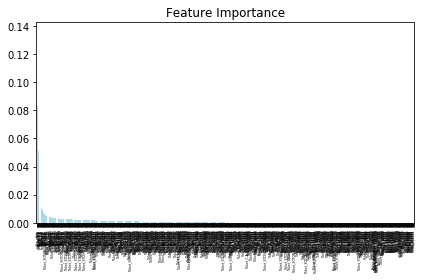

In [114]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning) 

%run -i AutoClassifier_titanic.py

https://www.kaggle.com/jirakst/titanic-auc-90

In [1]:
# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Common Tools
from sklearn.preprocessing import LabelEncoder
from collections import Counter

#Algorithms
from sklearn import ensemble, tree, svm, naive_bayes, neighbors, linear_model, gaussian_process, neural_network
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

# Model
from sklearn.metrics import accuracy_score, f1_score, auc, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
#from sklearn.ensemble import VotingClassifier

#Configure Defaults
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

C:\Users\hiroa\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
pd.__version__

'0.24.1'

In [3]:
np.__version__

'1.15.4'

In [4]:
sns.__version__

'0.9.0'

In [5]:
train = pd.read_csv('./data/org/train.csv')
train.shape

(891, 12)

In [6]:
test = pd.read_csv('./data/org/test.csv')
test.shape

(418, 11)

Survival rate:  0.3838383838383838


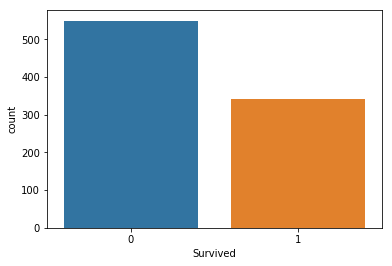

In [7]:
sns.countplot(x='Survived', data=train)
print("Survival rate: ", train.Survived.sum()/train.Survived.count())

大きな偏りはない

In [8]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


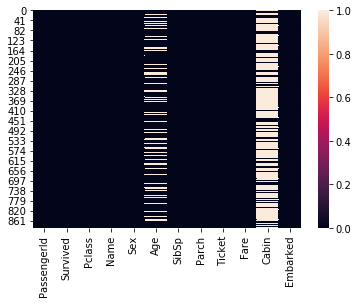

In [10]:
sns.heatmap(train.isnull())

Age,Cabinに nullがある

In [11]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Features SibSp, Parch, Fare are possible candidates for outlier removal

In [12]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


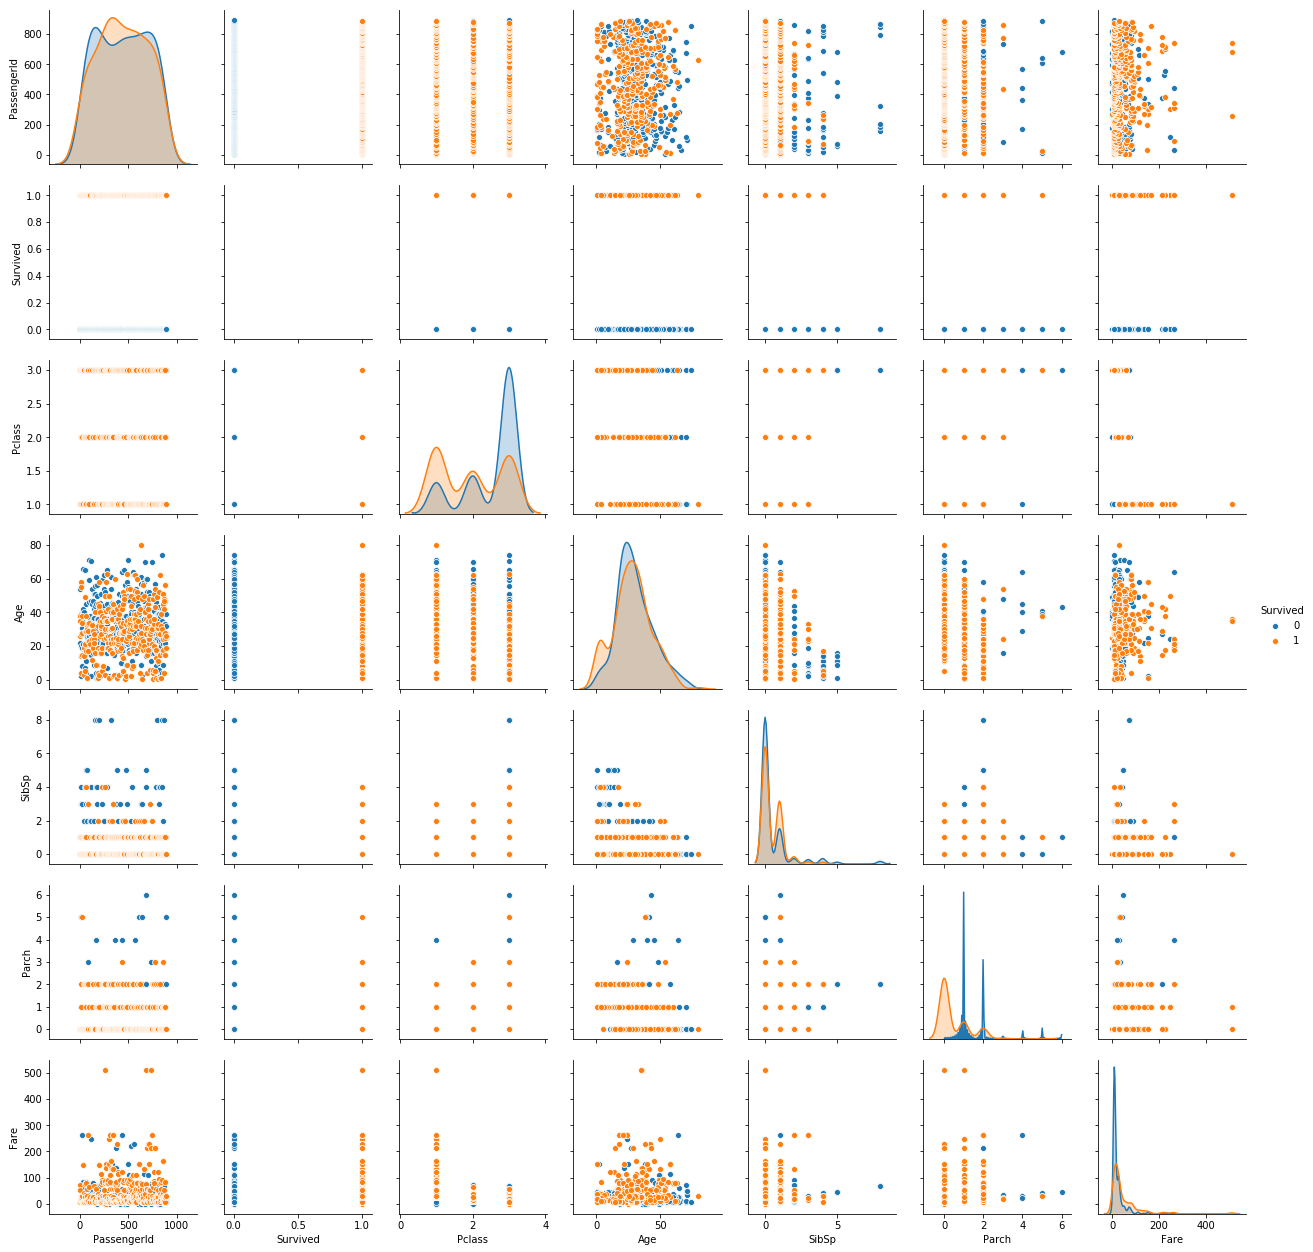

In [13]:
sns.pairplot(train, hue="Survived")

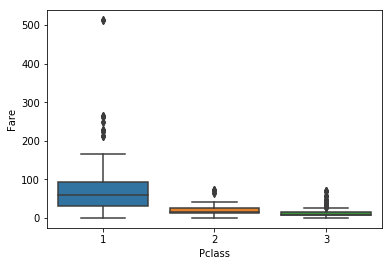

In [14]:
sns.boxplot(x="Pclass", y="Fare",data=train)

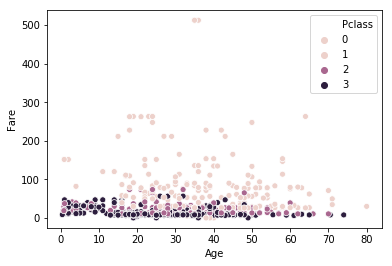

In [15]:
sns.scatterplot(x="Age", y="Fare", hue = 'Pclass', data=train)

500あたりの Fareは明らかに外れ値

In [16]:
train.groupby(['Parch'])['Survived'].count()

Parch
0    678
1    118
2     80
3      5
4      4
5      5
6      1
Name: Survived, dtype: int64

In [17]:
train.groupby(['SibSp'])['Survived'].count()

SibSp
0    608
1    209
2     28
3     16
4     18
5      5
8      7
Name: Survived, dtype: int64

We will deal with features Parch and SibSp using backets.

Outlier removal

I'm going to use an in-build function here instead of user-defined function based on Tukey method for the simplicty of the single feature.

In [18]:
q = train.Fare.quantile(0.99)
q

249.00622000000033

In [19]:
train = train[train['Fare'] < q]

In [20]:
#I'll concat train and test datasets for convenient feature handling. We will split them at the end for a model training and submission.
split = len(train)

In [21]:
data =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [22]:
data.shape

(1300, 12)

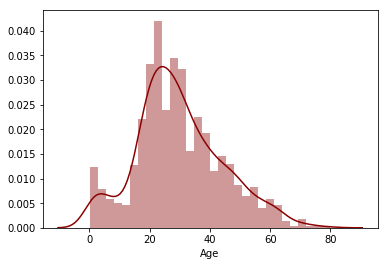

In [23]:
#Handle Nulls
sns.distplot(data['Age'].dropna(),color='darkred',bins=30)

In [24]:
median = data["Age"].median()
std = data["Age"].std()
is_null = data["Age"].isnull().sum()
rand_age = np.random.randint(median - std, median + std, size = is_null)
age_slice = data["Age"].copy()
age_slice[np.isnan(age_slice)] = rand_age
data["Age"] = age_slice
data["Age"] = data["Age"].astype(int)

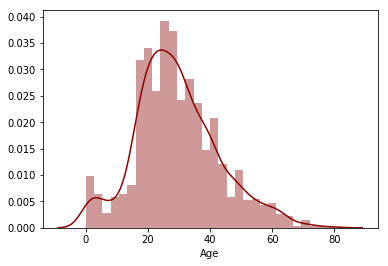

In [25]:
#Check
sns.distplot(data['Age'],color='darkred',bins=30)

In [26]:
#No change in the feature distribution. This is how we want to look it like.
data["Age"].isnull().sum()

0

In [27]:
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace = True)

data["Embarked"].isnull().sum()

0

In [28]:
data.isnull().sum()

Age               0
Cabin          1013
Embarked          0
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [29]:
data['Fare'].fillna(data['Fare'].mean(), inplace = True)

In [30]:
#Cabin
#The assumtion here is that people of higher sicio-economic status are more likely to have filled specific cabin number.
data["CabinBool"] = (data["Cabin"].notnull().astype('int'))

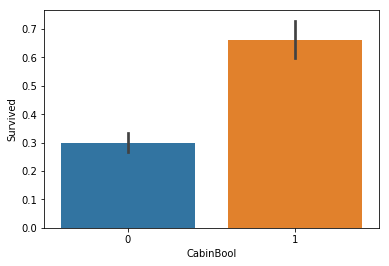

In [31]:
sns.barplot(x="CabinBool", y="Survived", data=data)

In [32]:
#Deck
data['Deck'] = data.Cabin.str.extract('([a-zA-Z]+)', expand=False)
data[['Cabin', 'Deck']].sample(10)
data['Deck'] = data['Deck'].fillna('Z')

In [33]:
data['Deck'] = LabelEncoder().fit_transform(data['Deck'])

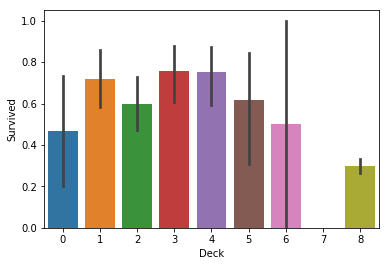

In [34]:
sns.barplot(x="Deck", y="Survived", data=data)

In [35]:
data.groupby(['Embarked'])['Survived'].count()

Embarked
C    163
Q     77
S    642
Name: Survived, dtype: int64

In [36]:
data['Embarked'] = LabelEncoder().fit_transform(data['Embarked'])

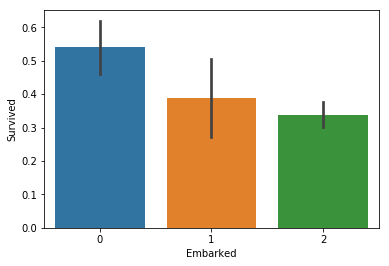

In [37]:
sns.barplot(x="Embarked", y="Survived", data=data)

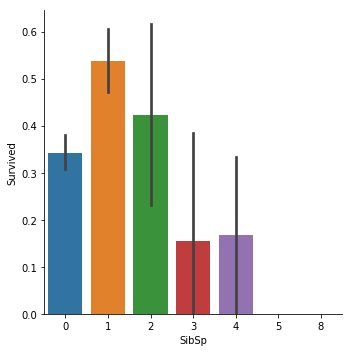

In [38]:
sns.factorplot(x="SibSp", y="Survived", data=train, kind="bar")

In [39]:
bins = [-1, 0, 2, np.inf]
labels = ['None', 'Small', 'Bigger']
data['SibSpBin'] = pd.cut(data["SibSp"], bins, labels = labels)

In [40]:
SibSpBin_mapping = {"None": 0, "Small": 1, "Bigger": 2}
data['SibSpBin'] = data['SibSpBin'].map(SibSpBin_mapping)

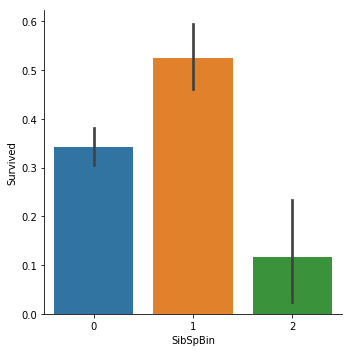

In [41]:
sns.factorplot(x="SibSpBin", y="Survived", data=data, kind="bar")

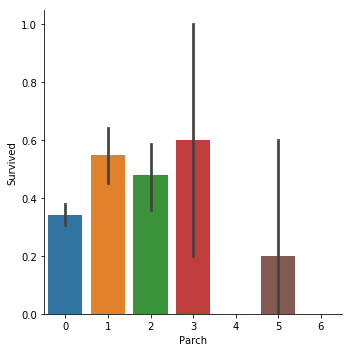

In [42]:
sns.factorplot(x="Parch", y="Survived", data=train, kind="bar")

In [43]:
bins = [-1, 0, 2, np.inf]
labels = ['None', 'Small', 'Bigger']
data['ParchBin'] = pd.cut(data["Parch"], bins, labels = labels)

In [44]:
ParchBin_mapping = {"None": 0, "Small": 1, "Bigger": 2}
data['ParchBin'] = data['ParchBin'].map(ParchBin_mapping)

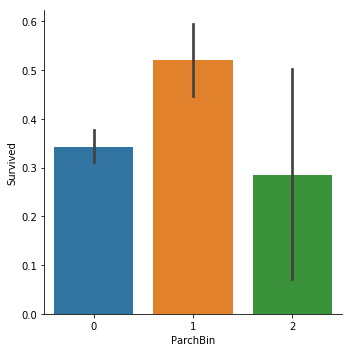

In [45]:
sns.factorplot(x="ParchBin", y="Survived", data=data, kind="bar")

In [46]:
#Family Size

data['FamilySize'] = data['SibSp'] + data['Parch']

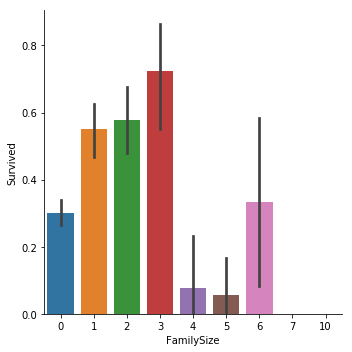

In [47]:
sns.factorplot(x="FamilySize", y="Survived", data=data, kind="bar")

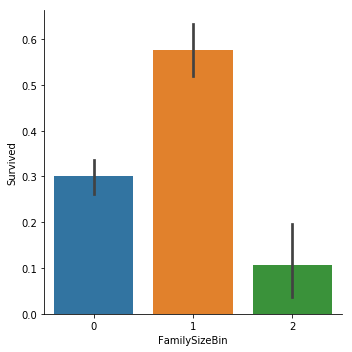

In [48]:

bins = [-1, 0, 3, np.inf]
labels = ['Alone', 'Small', 'Bigger']
data['FamilySizeBin'] = pd.cut(data["FamilySize"], bins, labels = labels)

FamilySizeBin_mapping = {"Alone": 0, "Small": 1, "Bigger": 2}
data['FamilySizeBin'] = data['FamilySizeBin'].map(FamilySizeBin_mapping)

sns.factorplot(x="FamilySizeBin", y="Survived", data=data, kind="bar")

In [49]:
data['IsAlone'] = 1 #default value

In [50]:
data['IsAlone'].loc[data['FamilySize'] > 0] = 0

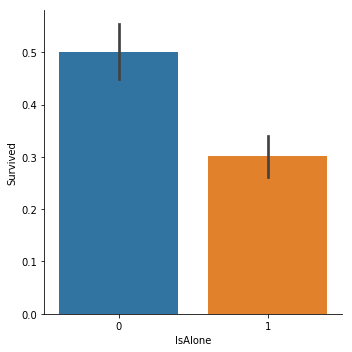

In [51]:
sns.factorplot(x="IsAlone", y="Survived", data=data, kind="bar")

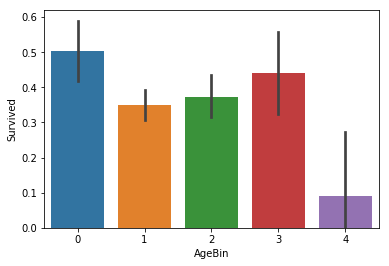

In [52]:
data['AgeBin'] = pd.cut(data['Age'].astype(int), 5)

data['AgeBin'] = LabelEncoder().fit_transform(data['AgeBin'])

sns.barplot(x="AgeBin", y="Survived", data=data)

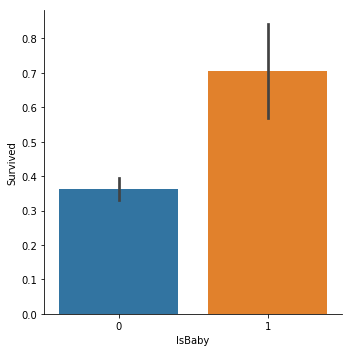

In [53]:
#is Baby

data['IsBaby'] = 0 #default value

data['IsBaby'].loc[data['Age'] < 6] = 1

sns.factorplot(x="IsBaby", y="Survived", data=data, kind="bar")

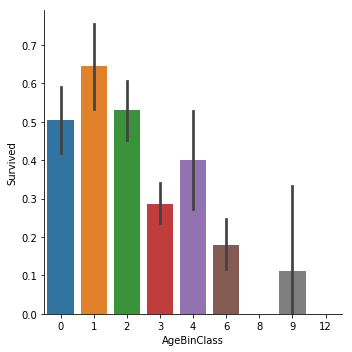

In [54]:
#AgeBin - Class

data['AgeBinClass']= data['AgeBin']* data['Pclass']

sns.factorplot(x="AgeBinClass", y="Survived", data=data, kind="bar")

In [55]:
#Name - Title

data['Title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

data['Title'] = data['Title'].replace(['Lady', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Dona'], 'Rare')  
data['Title'] = data['Title'].replace(['Countess', 'Lady', 'Sir'], 'Royal')
data['Title'] = data['Title'].replace('Mlle', 'Miss')
data['Title'] = data['Title'].replace('Ms', 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')

In [56]:
data['Title'] = data['Title'].replace(['Mr', 'Miss', 'Mrs', 'Master', 'Royal', 'Rare'], [0, 1, 2, 3, 4, 5]) # Other way to encode a feature

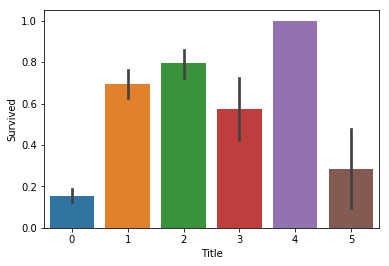

In [57]:
sns.barplot(x="Title", y="Survived", data=data)

In [58]:
#Sex

sex_mapping = {"male": 0, "female": 1}
data['Sex'] = data['Sex'].map(sex_mapping) # Yet another way to encode

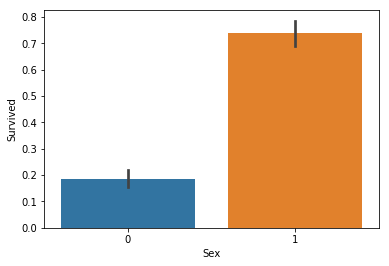

In [59]:
sns.barplot(x="Sex", y="Survived", data=data)

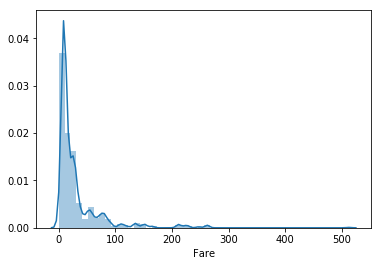

In [60]:
sns.distplot(data['Fare'])

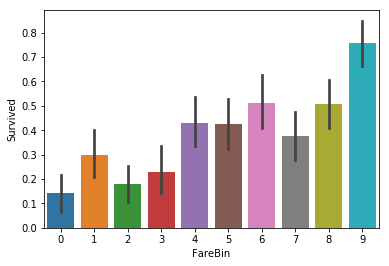

In [61]:
data['FareBin'] = pd.qcut(data['Fare'], 10)

data['FareBin'] = LabelEncoder().fit_transform(data['FareBin'])

sns.barplot(x="FareBin", y="Survived", data=data)

In [62]:
# Correlation

def correlation_heatmap(df, method):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(method=method),
        cmap = colormap,
        square=True, 
        annot=True, 
        annot_kws={'fontsize':9 }
    )
    
    plt.title('Correlation Matrix', y=1.05, size=15)

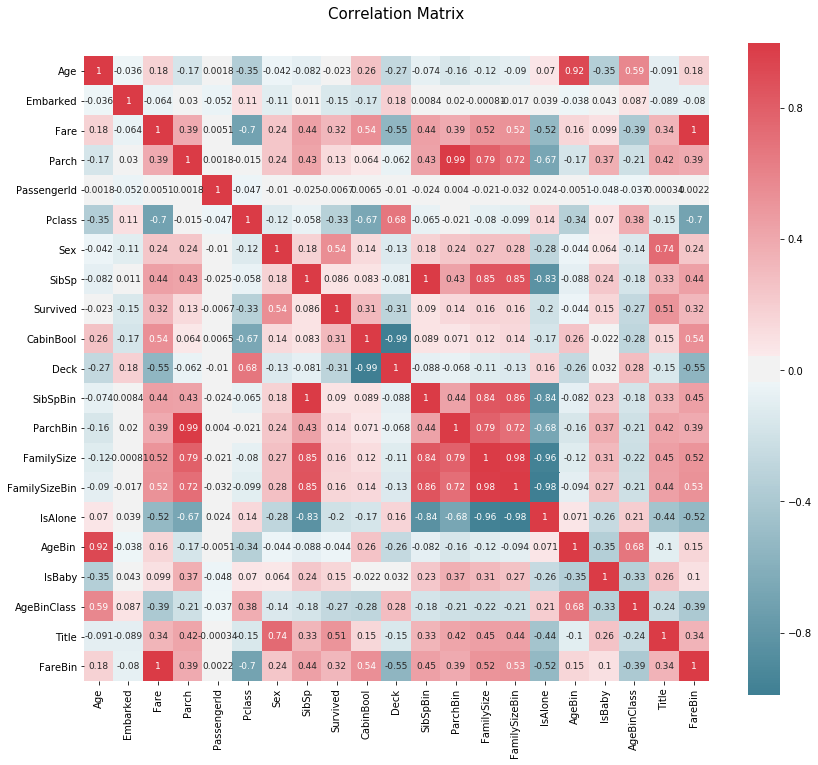

In [63]:
correlation_heatmap(data, 'spearman')

In [64]:
#Drop low-correlated features
to_drop = ["SibSpBin", "AgeBin", "SibSp", "Age"]
data.drop(to_drop, axis=1, inplace=True)

In [65]:
#Check
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 20 columns):
Cabin            287 non-null object
Embarked         1300 non-null int64
Fare             1300 non-null float64
Name             1300 non-null object
Parch            1300 non-null int64
PassengerId      1300 non-null int64
Pclass           1300 non-null int64
Sex              1300 non-null int64
Survived         882 non-null float64
Ticket           1300 non-null object
CabinBool        1300 non-null int32
Deck             1300 non-null int64
ParchBin         1300 non-null int64
FamilySize       1300 non-null int64
FamilySizeBin    1300 non-null int64
IsAlone          1300 non-null int64
IsBaby           1300 non-null int64
AgeBinClass      1300 non-null int64
Title            1300 non-null int64
FareBin          1300 non-null int64
dtypes: float64(2), int32(1), int64(14), object(3)
memory usage: 198.1+ KB


In [66]:
# Drop high-cardinality features
data.drop(['Ticket', 'Cabin', 'Name', 'Fare'],axis=1,inplace=True)

In [67]:
#Check
data.columns

Index(['Embarked', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'Survived',
       'CabinBool', 'Deck', 'ParchBin', 'FamilySize', 'FamilySizeBin',
       'IsAlone', 'IsBaby', 'AgeBinClass', 'Title', 'FareBin'],
      dtype='object')

In [68]:
#Model
#Prepeare data

#Split data
train = data[:split]
test = data[split:]

# Get variables for a model
x = train.drop(["Survived", "PassengerId"], axis=1)
y = train["Survived"]

#Do train data splitting
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.22, random_state=101)

In [76]:
#I've noticed some people here on Kaggle score their model base on train dataset which obviously yields high accuracy. 
#I think the correct approache is to fit a model based on train data and score it based on test data.
MLA = [
    ensemble.AdaBoostClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    gaussian_process.GaussianProcessClassifier(),
    linear_model.LogisticRegressionCV(),
    linear_model.RidgeClassifierCV(),
    linear_model.Perceptron(),
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    neighbors.KNeighborsClassifier(),
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    xgb.XGBClassifier()
    ]

In [77]:
#Do some preperation for the loop
col = []
algorithms = pd.DataFrame(columns = col)
idx = 0

#Train and score algorithms
for a in MLA:
    
    a.fit(X_train, y_train)
    pred = a.predict(X_test)
    acc = accuracy_score(y_test, pred) #Other way: a.score(X_test, y_test)
    f1 = f1_score(y_test, pred)
    cv = cross_val_score(a, X_train, y_train).mean()
    
    Alg = a.__class__.__name__
    
    algorithms.loc[idx, 'Algorithm'] = Alg
    algorithms.loc[idx, 'Accuracy'] = round(acc * 100, 2)
    algorithms.loc[idx, 'F1 Score'] = round(f1 * 100, 2)
    algorithms.loc[idx, 'CV Score'] = round(cv * 100, 2)

    idx+=1

In [78]:
#Compare invidual models
algorithms.sort_values(by = ['CV Score'], ascending = False, inplace = True)    
algorithms.head()

,Algorithm,Accuracy,F1 Score,CV Score
11,SVC,82.56,78.48,83.11
16,XGBClassifier,81.03,76.43,82.82
12,NuSVC,82.56,77.92,82.82
2,GradientBoostingClassifier,80.00,75.47,82.10
13,LinearSVC,81.54,76.92,81.95


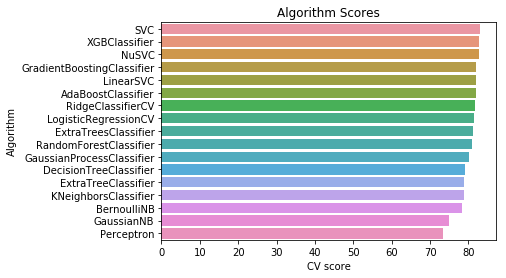

In [79]:
#Plot them
g = sns.barplot("CV Score", "Algorithm", data = algorithms)
g.set_xlabel("CV score")
g = g.set_title("Algorithm Scores")

In [80]:
# Evaluation(Parameter Tunning
# The training dataset isn't large, so I've decided to choice GridSearchCV over RandomizedSearchCV for the 3 best model performers here.
kfold = StratifiedKFold(n_splits=10) #-> library from sklearn.model_selection import StratifiedKFold

In [86]:
xgb.__version__

'0.71'

In [92]:
# XGBoost Classifier
XGB = XGBClassifier()
xgb_param = {
#    'loss' : ["deviance"],
     'n_estimators' : [100,200,300,500],
     'learning_rate': [0.1, 0.05, 0.01],
     'max_depth': [4, 8, 12],
#     'min_samples_leaf': [100,150],
#     'max_features': [0.3, 0.1] 
    }

gsXGB = GridSearchCV(XGB, param_grid = xgb_param, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsXGB.fit(X_train,y_train)
XGB_best = gsXGB.best_estimator_

# Best score
gsXGB.best_score_

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.7s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:   30.9s finished


0.834061135371179

In [93]:
# SVC Classifier
SVC = svm.SVC(probability=True)
svc_param = {
    'kernel': ['rbf'], 
    'gamma': [ 0.001, 0.01, 0.1, 1],
    'C': [1, 10, 50, 100,200,300, 1000]
    }

gsSVC = GridSearchCV(SVC, param_grid = svc_param, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsSVC.fit(X_train,y_train)
SVC_best = gsSVC.best_estimator_

# Best score
gsSVC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   11.7s finished


0.8311499272197962

In [94]:
# Gradient Boosting Classifier
GB = ensemble.GradientBoostingClassifier()
gb_param = {
        'loss' : ["deviance"],
        'n_estimators' : [100,200,300],
        'learning_rate': [0.1, 0.05, 0.01],
        'max_depth': [4, 8],
        'min_samples_leaf': [100,150],
        'max_features': [0.3, 0.1] 
        }

gsGB = GridSearchCV(GB, param_grid = gb_param, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsGB.fit(X_train,y_train)
GB_best = gsGB.best_estimator_

# Best score
gsGB.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 340 tasks      | elapsed:    9.9s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   18.4s finished


0.8224163027656477

In [95]:
vc = ensemble.VotingClassifier(
    estimators = [('xgb', XGB_best), ('gbc',GB_best), ('svc', SVC_best)],
    voting='soft', n_jobs=4)

In [96]:
vc = vc.fit(X_train, y_train)
pred = vc.predict(X_test)
acc = accuracy_score(y_test, pred) #Other way: vc.score(X_test, y_test)
f1 = f1_score(y_test, pred)
cv = cross_val_score(vc, X_train, y_train).mean()

print("Accuracy: ", round(acc*100,2), "\nF1-Score: ", round(f1*100,2), "\nCV Score: ", round(cv*100,2))

Accuracy:  82.56 
F1-Score:  78.21 
CV Score:  83.55


In [97]:
y_scores = vc.predict_proba(X_train)
y_scores = y_scores[:,1]

In [98]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_scores)

In [99]:
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

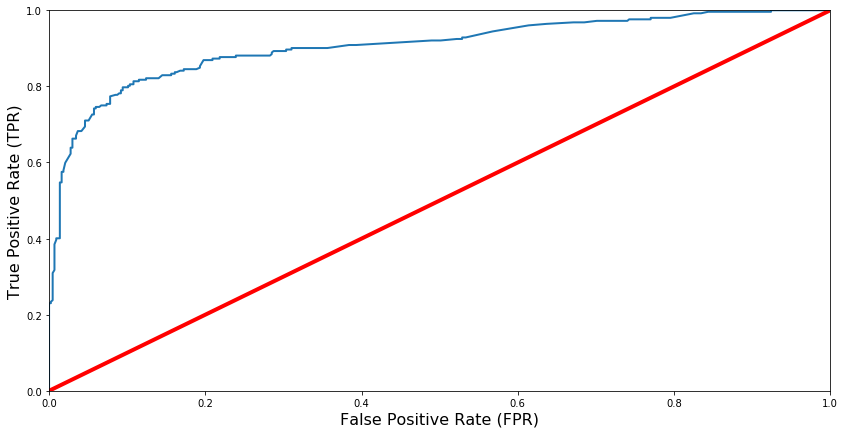

In [100]:
plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)

In [101]:
auroc = roc_auc_score(y_train, y_scores)
print("ROC-AUC Score:", auroc)

ROC-AUC Score: 0.9058064221857326


In [115]:
Id = test['PassengerId']
pred = vc.predict(X_test)
output = pd.concat([pd.DataFrame(Id), pd.DataFrame(pred)], axis=1)
output.to_csv('submission.csv', index=False, header=True)

#IDs = test.iloc[:,[0]]
#pred = vc.predict(X_test)
##pred = pd.DataFrame(vc.predict(X_test)[:,1])
#pred = pd.DataFrame(vc.predict(X_test)[:,1], columns=['Survived'])
#IDs.join(pred).to_csv('./'+'submission.csv')


https://www.kaggle.com/startupsci/titanic-data-science-solutions

https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy

https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling